In [1]:
import pandas as pd
from example.nuscenes.av_discretizer  import AVDiscretizer
from example.nuscenes.transition import TransitionRecorded
from nuscenes import NuScenes
import matplotlib.pyplot as plt


In [2]:
# This is the path where you stored your copy of the nuScenes dataset.

#DATAROOT = Path("C:/Users/sara_/Desktop/MasterThesis/pgeon-main/example/nuscenes/data/sets/nuscenes")
DATAROOT = '/home/saramontese/Desktop/MasterThesis/example/nuscenes/dataset/data/sets/nuscenes'
nuscenes = NuScenes('v1.0-mini', dataroot=DATAROOT)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.452 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


# Data Analysis


The dataset contains the following columns for each state of the self-driving car:

- instance_token: A unique identifier for the vehicle instance.
- translation: The vehicle's position in 3D space (x, y, z coordinates).
- yaw: The orientation of the vehicle around the vertical axis (rotation angle).
- velocity: The vehicle's speed in a given direction.
- acceleration: The change in velocity over time.
- heading_change_rate: The rate of change of the vehicle's direction.
- timestamp: The time at which the state was recorded.
- scene_token: A unique identifier for the scenario or environment the vehicle is in

# Load the CSV data into a DataFrame


In [3]:

dtype_dict = {
    'modality': 'category',  # for limited set of modalities, 'category' is efficient
    'scene_token': 'str',  
    'timestamp': 'str',  # To enable datetime operations
    'rotation': 'object',  # Quaternion (lists)
    'x': 'float64',
    'y': 'float64',
    'z': 'float64',
    'yaw': 'float64',  
    'velocity': 'float64',
    'acceleration': 'float64',
    'heading_change_rate': 'float64',
    'delta_local_x': 'float64',
    'delta_local_y': 'float64'
}

df = pd.read_csv('/home/saramontese/Desktop/MasterThesis/example/nuscenes/dataset/dataset_from_ego.csv', dtype=dtype_dict, parse_dates=['timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'])




df.head()

,modality,scene_token,timestamp,rotation,x,y,z,yaw,velocity,acceleration,heading_change_rate,delta_local_x,delta_local_y
0,lidar,2fc3753772e241f2ab2cd16a784cc680,2018-08-30 19:25:09.301132,"[-0.1557237496690409, 0.011222825001502285, 0....",329.647494,660.196689,0.0,2.828707,5.108550,-0.034804,-0.045330,0.000000,0.000000
1,lidar,2fc3753772e241f2ab2cd16a784cc680,2018-08-30 19:25:09.801064,"[-0.16117694469754024, 0.009157178788916257, 0...",327.233834,661.025514,0.0,2.817706,5.104695,-0.007711,-0.022006,0.045648,2.551592
2,lidar,2fc3753772e241f2ab2cd16a784cc680,2018-08-30 19:25:10.200261,"[-0.16222999791894513, 0.010261981974878865, -...",325.362312,661.686833,0.0,2.815673,4.972301,-0.331650,-0.005091,0.031316,1.984681
3,lidar,2fc3753772e241f2ab2cd16a784cc680,2018-08-30 19:25:10.651414,"[-0.16605361559690043, 0.007585584174464603, -...",323.362925,662.405363,0.0,2.807968,4.709219,-0.583132,-0.017080,0.040541,2.124192
4,lidar,2fc3753772e241f2ab2cd16a784cc680,2018-08-30 19:25:11.149672,"[-0.1790782272855317, 0.009448521999393368, -0...",321.358449,663.164911,0.0,2.781689,4.302103,-0.817080,-0.052741,0.061262,2.142681


In [4]:
df.shape

(384, 13)

### Compute deltas for relevant columns

In [5]:
# Assuming 'df' is your DataFrame and it has 'x', 'y', 'z' columns for position
delta_df = pd.DataFrame()
delta_df['x_diff'] = df.groupby('scene_token')['x'].diff()
delta_df['y_diff'] = df.groupby('scene_token')['y'].diff()
delta_df['z_diff'] = df.groupby('scene_token')['z'].diff()
delta_df['velocity_diff'] = df.groupby('scene_token')['velocity'].diff()
delta_df['acceleration_diff'] = df.groupby('scene_token')['acceleration'].diff()
delta_df['yaw_diff'] = df.groupby('scene_token')['yaw'].diff()
delta_df['heading_change_rate_diff'] = df.groupby('scene_token')['heading_change_rate'].diff()


In [6]:
# Assuming 'df' is your DataFrame and it has 'x', 'y', 'z' columns for position
abs_df = pd.DataFrame()
abs_df['abs_x_diff'] = df.groupby('scene_token')['x'].diff().abs()
abs_df['abs_y_diff'] = df.groupby('scene_token')['y'].diff().abs()
abs_df['abs_z_diff'] = df.groupby('scene_token')['z'].diff().abs()
abs_df['abs_velocity_diff'] = df.groupby('scene_token')['velocity'].diff().abs()
abs_df['abs_acceleration_diff'] = df.groupby('scene_token')['acceleration'].diff().abs()
abs_df['abs_yaw_diff'] = df.groupby('scene_token')['yaw'].diff().abs()
abs_df['abs_heading_change_rate_diff'] = df.groupby('scene_token')['heading_change_rate'].diff().abs()


### Compute statistics to understand their distribution

Original Dataset

In [7]:
stats = df[['velocity', 'acceleration', 'yaw', 'heading_change_rate']].describe()
stats.loc[['mean', 'std', 'min', 'max']]

,velocity,acceleration,yaw,heading_change_rate
mean,5.648337e+00,0.044867,0.199002,-0.023742
std,4.702125e+00,0.592547,1.985583,1.079821
min,1.307423e-07,-3.251616,-3.045028,-12.232000
max,1.516489e+01,1.661893,3.120576,12.088103


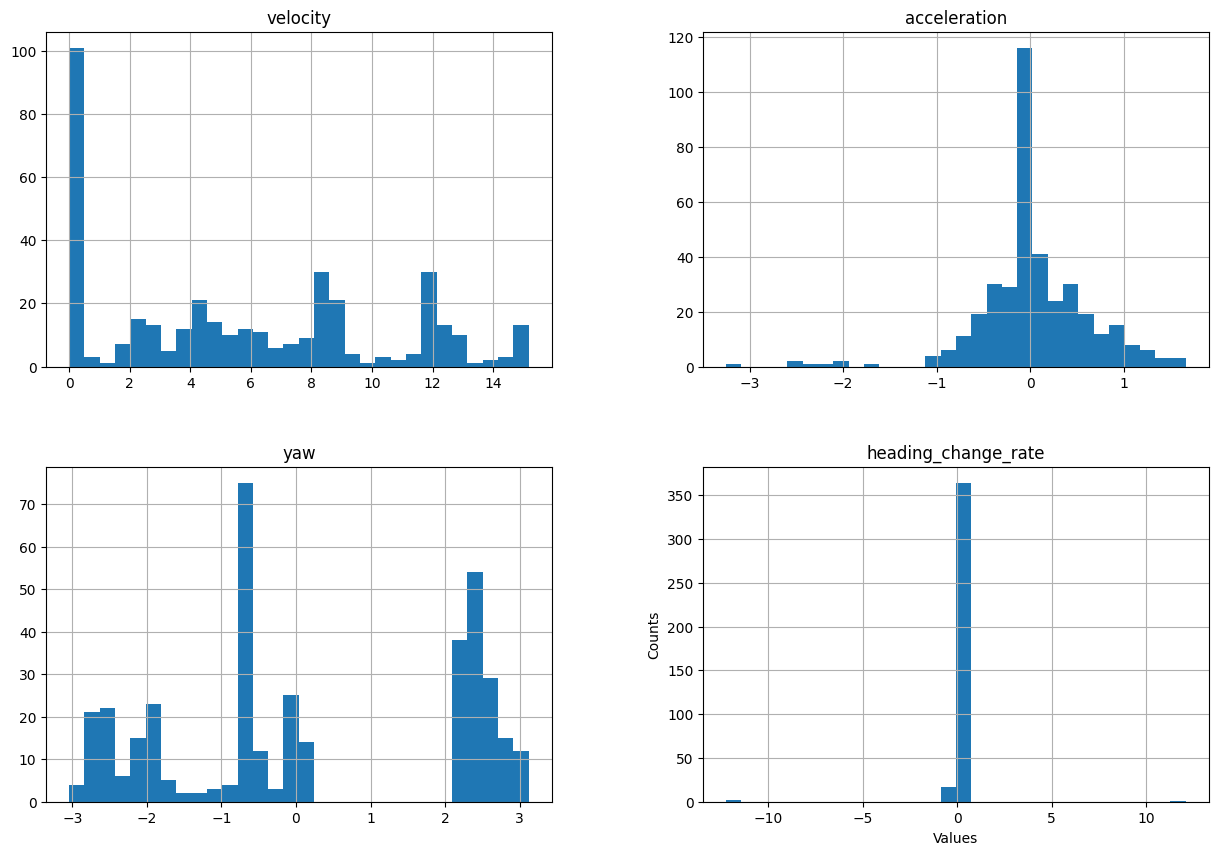

In [8]:
df[['velocity', 'acceleration', 'yaw', 'heading_change_rate']].hist(bins=30, figsize=(15, 10))

plt.xlabel("Values")
plt.ylabel("Counts")
plt.show()

Correlation matrix

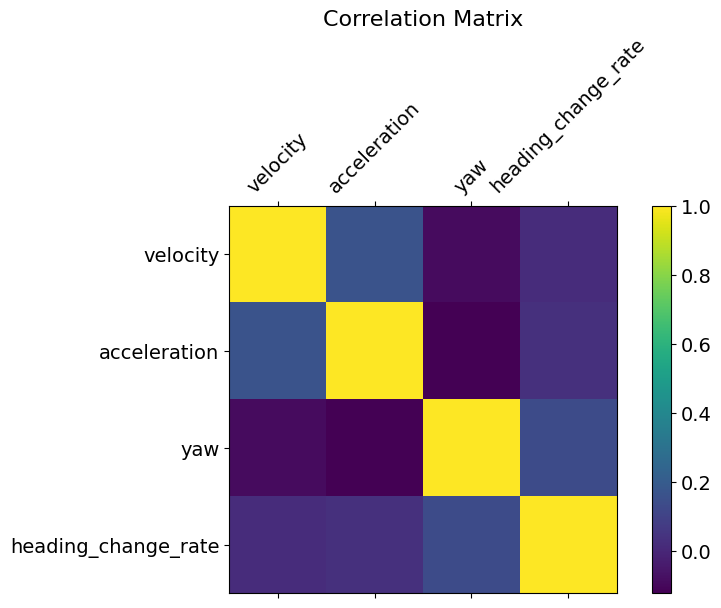

In [25]:
f = plt.figure(figsize=(9, 5))
numeric_df = df[['velocity', 'acceleration', 'yaw', 'heading_change_rate']]
plt.matshow(numeric_df.corr(), fignum=f.number)
plt.xticks(range(numeric_df.select_dtypes(['number']).shape[1]), numeric_df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(numeric_df.select_dtypes(['number']).shape[1]), numeric_df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Variation  Dataset

In [10]:
stats = delta_df[['x_diff', 'y_diff', 'z_diff', 'velocity_diff', 'acceleration_diff', 'yaw_diff', 'heading_change_rate_diff']].describe()
stats.loc[['mean', 'std', 'min', 'max']]


,x_diff,y_diff,z_diff,velocity_diff,acceleration_diff,yaw_diff,heading_change_rate_diff
mean,0.377432,-0.550399,0.0,0.021818,-0.006074,-0.012051,0.001365
std,2.631656,2.476047,0.0,0.293477,0.370391,0.547138,1.591383
min,-4.172880,-5.705460,0.0,-1.298237,-1.662225,-6.121174,-12.602398
max,6.338054,4.971892,0.0,0.828863,1.588390,6.042274,12.640437


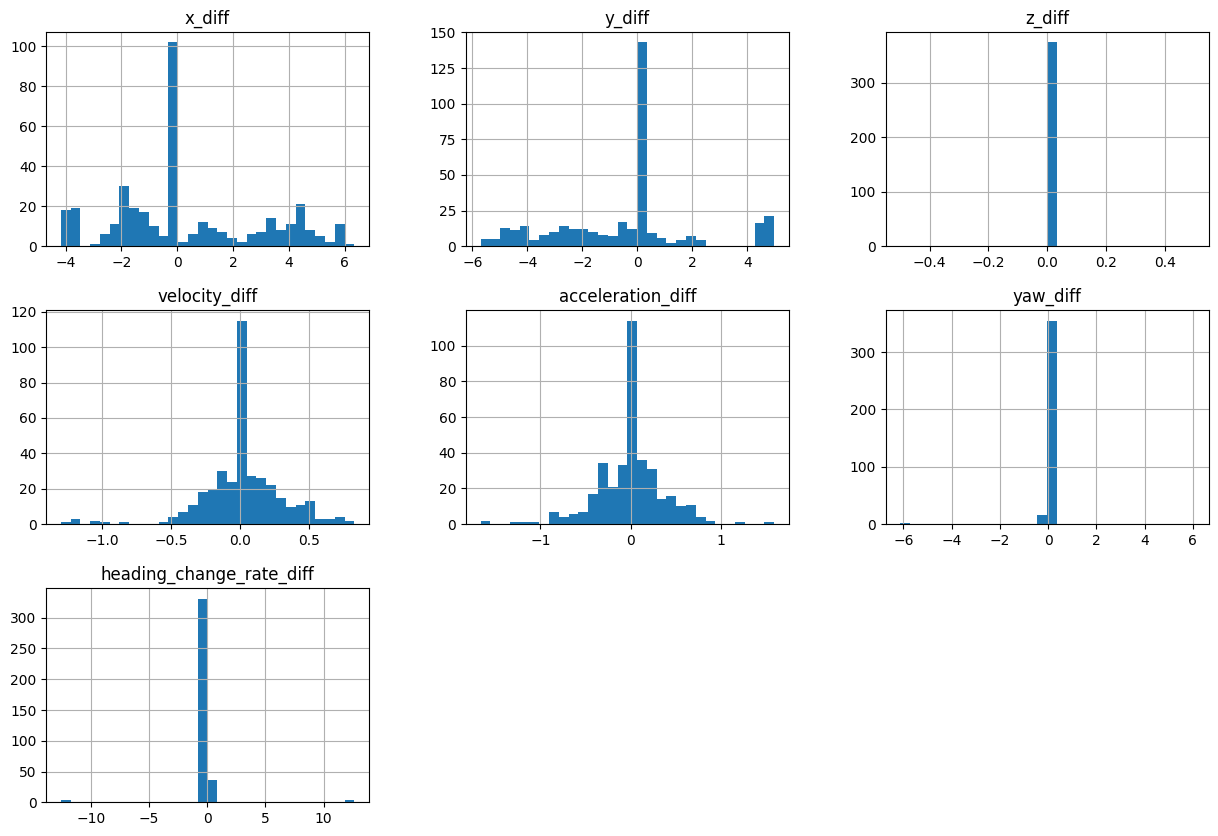

In [11]:
delta_df[['x_diff', 'y_diff', 'z_diff', 'velocity_diff', 'acceleration_diff', 'yaw_diff', 'heading_change_rate_diff']].hist(bins=30, figsize=(15, 10))

plt.xlabel("Values")
plt.ylabel("Counts")
plt.show()

Correlation Matrix


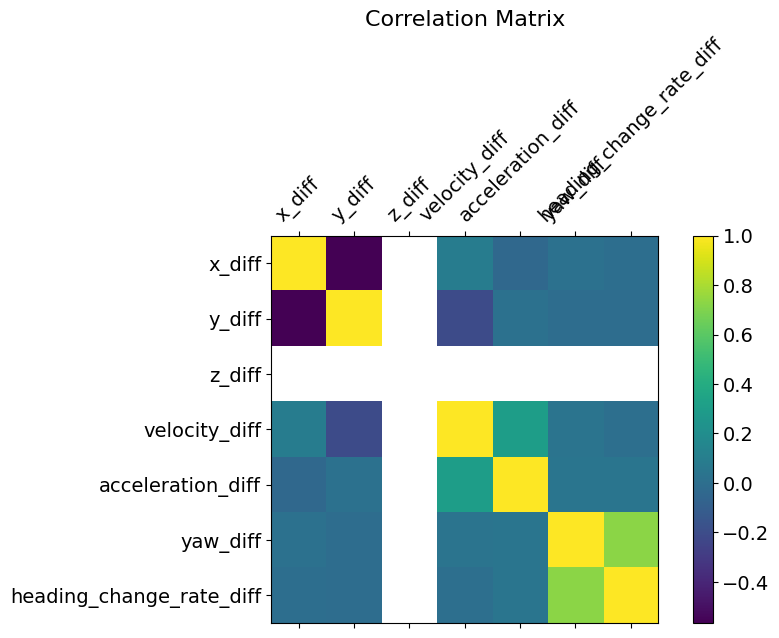

In [26]:
f = plt.figure(figsize=(9, 5))
plt.matshow(delta_df.corr(), fignum=f.number)
plt.xticks(range(delta_df.select_dtypes(['number']).shape[1]), delta_df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(delta_df.select_dtypes(['number']).shape[1]), delta_df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Absolute Variation Dataset

In [13]:
abs_stats = abs_df[['abs_x_diff', 'abs_y_diff', 'abs_z_diff', 'abs_velocity_diff', 'abs_acceleration_diff', 'abs_yaw_diff', 'abs_heading_change_rate_diff']].describe()
abs_stats.loc[['mean', 'std', 'min', 'max']]


,abs_x_diff,abs_y_diff,abs_z_diff,abs_velocity_diff,abs_acceleration_diff,abs_yaw_diff,abs_heading_change_rate_diff
mean,2.004027e+00,1.724144e+00,0.0,0.191920,2.483478e-01,6.820299e-02,0.214334
std,1.744007e+00,1.858472e+00,0.0,0.222876,2.745617e-01,5.429931e-01,1.576844
min,3.825562e-09,6.531832e-08,0.0,0.000001,8.449540e-07,2.501108e-07,0.000006
max,6.338054e+00,5.705460e+00,0.0,1.298237,1.662225e+00,6.121174e+00,12.640437


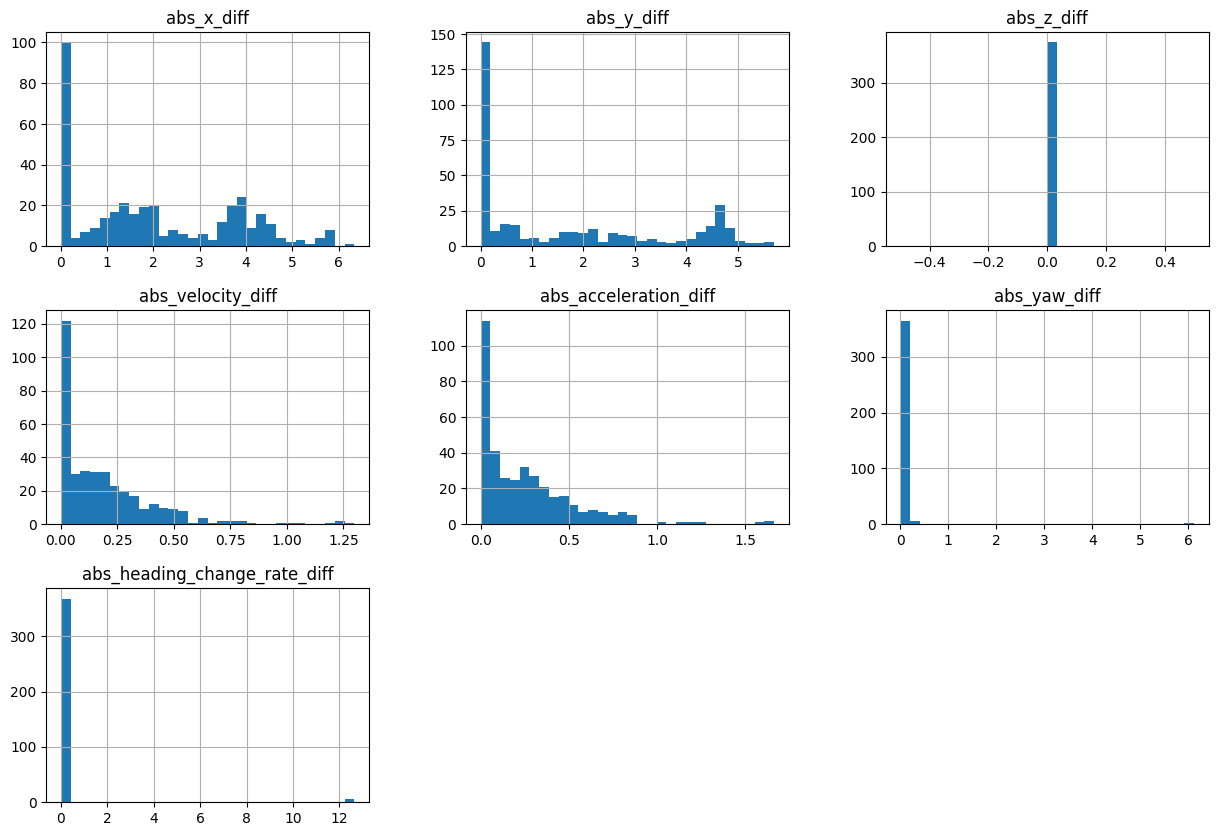

In [14]:
abs_df[['abs_x_diff', 'abs_y_diff', 'abs_z_diff', 'abs_velocity_diff', 'abs_acceleration_diff', 'abs_yaw_diff', 'abs_heading_change_rate_diff']].hist(bins=30, figsize=(15, 10))

plt.xlabel("Values")
plt.ylabel("Counts")
plt.show()

Interpretation:
- x_diff:
- y_diff:
Since these have broader distributions, setting a threshold might require considering the context of the movement. If you're looking to detect significant lateral movements (e.g., lane changes), you might set a threshold around the higher frequency lower-end values.

- z_diff: The z differences are concentrated near zero with a very sharp peak, indicating that there is very little change in the vertical position, which is expected for a vehicle traveling on relatively flat surfaces. (0.05-0.1)


- velocity_diff: high concentration at the lower end, suggesting that velocity changes between consecutive measurements are generally small, with occasional larger changes.
    Plausible threshold to detect meaningful acceleration or deceleration might be set just above the most frequent low-end changes, possibly in the range where the histogram bars start to significantly lower. (0.1-0.2 m/s)


- acceleration_diff: most acceleration changes are close to zero, with a few instances of larger differences. This pattern is typical for driving in urban environments, where acceleration and deceleration are frequent but not extreme. Threshold might be set at a value that excludes the majority of these minor changes but captures the less frequent larger changes. (5-10)


- yaw_diff: histogram is highly skewed towards smaller values, indicating that most of the time, there are only slight changes in orientation, which corresponds to driving mostly straight with occasional turns. (0.1-0.2)


- heading_change_rate_diff:Similar to yaw_diff, the histogram for heading change rate differences is skewed towards smaller values. The vehicle mostly maintains its heading with only slight variations within the sampled timeframe. (0.01-0.02)



# Determine Trajectory in Scene's Instances

In [15]:
# Initialize your AVDiscretizer
av_discretizer = AVDiscretizer()


### Let's do an example of computing trajectory of an instance of a scene. We then check if the images of the instace match the actions in the trajectory.

In [16]:
df['scene_token'].unique()

array(['2fc3753772e241f2ab2cd16a784cc680',
       '325cef682f064c55a255f2625c533b75',
       '6f83169d067343658251f72e1dd17dbc',
       'bebf5f5b2a674631ab5c88fd1aa9e87a',
       'c5224b9b454b4ded9b5d2d2634bbda8a',
       'cc8c0bf57f984915a77078b10eb33198',
       'd25718445d89453381c659b9c8734939',
       'de7d80a1f5fb4c3e82ce8a4f213b450a',
       'e233467e827140efa4b42d2b4c435855',
       'fcbccedd61424f1b85dcbf8f897f9754'], dtype=object)

Select a scene and test the  algorithm


In [17]:
scene_test = 'fcbccedd61424f1b85dcbf8f897f9754'
instance1_example_df = df[df['scene_token']==scene_test]
instance1_example_df

,modality,scene_token,timestamp,rotation,x,y,z,yaw,velocity,acceleration,heading_change_rate,delta_local_x,delta_local_y
346,lidar,fcbccedd61424f1b85dcbf8f897f9754,2018-08-01 19:26:44.547893,"[-0.9627518337207462, -0.007396822537559821, -...",607.454126,1643.214922,0.0,-0.547173,8.459599,-0.110979,-0.054958,0.000000,0.000000
347,lidar,fcbccedd61424f1b85dcbf8f897f9754,2018-08-01 19:26:45.047769,"[-0.9586126567859742, -0.00886558613167834, -0...",610.979678,1640.979419,0.0,-0.576383,8.351201,-0.216850,-0.058436,0.074861,4.173894
348,lidar,fcbccedd61424f1b85dcbf8f897f9754,2018-08-01 19:26:45.548192,"[-0.9545687821658851, -0.010115361549900212, -...",614.448524,1638.649312,0.0,-0.603276,8.350516,-0.001369,-0.053741,0.063150,4.178313
349,lidar,fcbccedd61424f1b85dcbf8f897f9754,2018-08-01 19:26:46.048630,"[-0.9508778105992817, -0.007438394839078251, -...",617.934112,1636.160092,0.0,-0.627174,8.558842,0.416287,-0.047754,0.072299,4.282559
350,lidar,fcbccedd61424f1b85dcbf8f897f9754,2018-08-01 19:26:46.549066,"[-0.9462014572093829, -0.01240051736543214, -0...",621.413034,1633.525589,0.0,-0.657550,8.720168,0.322372,-0.060698,0.091490,4.362927
351,lidar,fcbccedd61424f1b85dcbf8f897f9754,2018-08-01 19:26:47.048933,"[-0.9429247742619197, -0.010571617513262228, -...",624.903255,1630.734415,0.0,-0.678201,8.940455,0.440690,-0.041313,0.076042,4.468391
352,lidar,fcbccedd61424f1b85dcbf8f897f9754,2018-08-01 19:26:47.548824,"[-0.9408639180695122, -0.0013993408319602832, ...",628.343092,1627.868327,0.0,-0.691232,8.956713,0.032524,-0.026068,0.073702,4.476773
353,lidar,fcbccedd61424f1b85dcbf8f897f9754,2018-08-01 19:26:48.048151,"[-0.9400459441148465, 0.0027504532388893444, -...",631.769556,1624.966390,0.0,-0.696039,8.992504,0.071678,-0.009627,0.051504,4.489904
354,lidar,fcbccedd61424f1b85dcbf8f897f9754,2018-08-01 19:26:48.548020,"[-0.9408271137099451, -0.0030042154187013242, ...",635.119301,1622.120959,0.0,-0.691399,8.792587,-0.399938,0.009283,0.035750,4.394996
355,lidar,fcbccedd61424f1b85dcbf8f897f9754,2018-08-01 19:26:49.047890,"[-0.940954152018687, -0.008573445664225235, -0...",638.079084,1619.612347,0.0,-0.690220,7.761774,-2.062163,0.002359,0.045317,3.879613


I compute the trajectoy of the scene. Theb, for each sample in the scene, I retrive the images :

In [18]:
recorder = TransitionRecorded()
trajectory = av_discretizer.compute_trajectory(instance1_example_df)
# After processing all trajectories:
TransitionRecorded.process_and_save_transitions(trajectory, av_discretizer.unique_states)

State 0: [0.0, 0.0, 8.45959897231373, -0.5471726792472146, -0.0549577946917311, -0.1109792421435031, Timestamp('2018-08-01 19:26:44.547893')]
Discretized state: 0 [(151, 410)]&[<Velocity.MEDIUM: 3>]&[<Rotation.FORWARD: 3>]
Action: {<Action.STRAIGHT: 11>}

State 1: [0.0748610823493907, 4.173893679808763, 8.351201024259057, -0.5763833446259313, -0.0584358228414981, -0.2168496748287036, Timestamp('2018-08-01 19:26:45.047769')]
Discretized state: 1 [(152, 410)]&[<Velocity.MEDIUM: 3>]&[<Rotation.FORWARD: 3>]
Action: {<Action.STRAIGHT: 11>}

State 2: [0.06314985455333, 4.1783130577741225, 8.350515953787554, -0.6032764943975175, -0.0537408347969341, -0.0013689827835713, Timestamp('2018-08-01 19:26:45.548192')]
Discretized state: 2 [(153, 409)]&[<Velocity.MEDIUM: 3>]&[<Rotation.FORWARD: 3>]
Action: {<Action.STRAIGHT: 11>}

State 3: [0.0722991500339056, 4.282559332038052, 8.558841602728574, -0.6271743980114108, -0.0477539747459092, 0.4162866307934655, Timestamp('2018-08-01 19:26:46.048630')]
Di

Plot trend of state in time for each instance of a scene.

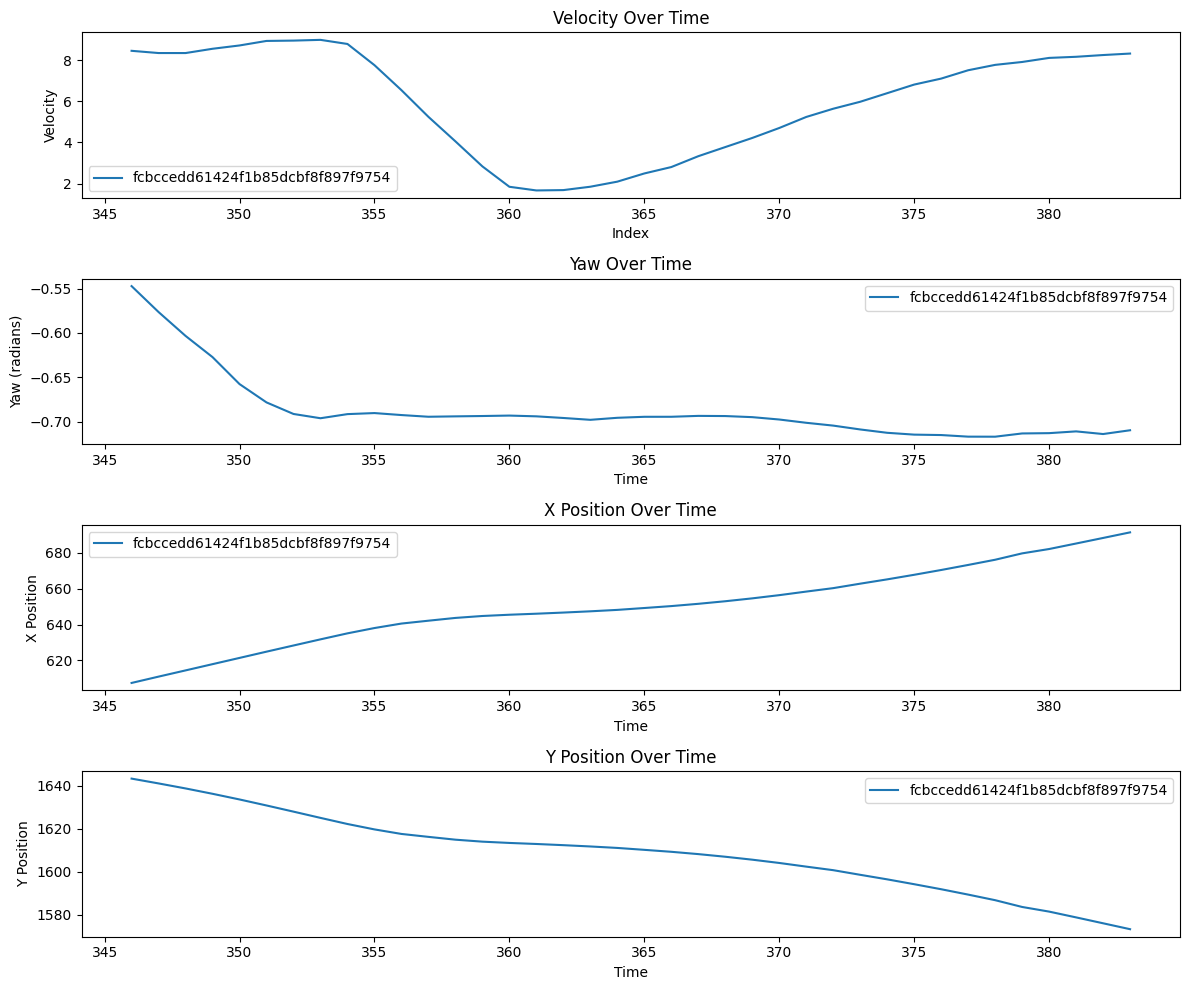

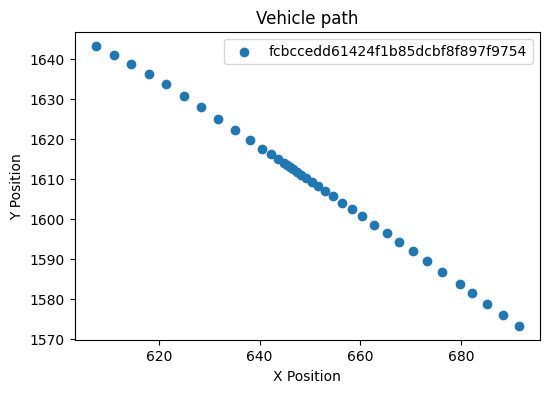

In [27]:
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
for instance_token, group in instance1_example_df.groupby('scene_token'):
    plt.plot(group.index, group['velocity'], label=instance_token)
plt.title('Velocity Over Time')
plt.xlabel('Index')
plt.ylabel('Velocity')
plt.legend()

plt.subplot(4, 1, 2)
for instance_token, group in instance1_example_df.groupby('scene_token'):
    plt.plot(group.index, group['yaw'], label=instance_token)
plt.title('Yaw Over Time')
plt.xlabel('Time')
plt.ylabel('Yaw (radians)')
plt.legend()

plt.subplot(4, 1, 3)
for instance_token, group in instance1_example_df.groupby('scene_token'):
    plt.plot(group.index, group['x'], label=instance_token)
plt.title('X Position Over Time')
plt.xlabel('Time')
plt.ylabel('X Position')
plt.legend()

plt.subplot(4, 1, 4)  # Moved inside the same plt.figure block
for instance_token, group in instance1_example_df.groupby('scene_token'):
    plt.plot(group.index, group['y'], label=instance_token)
plt.title('Y Position Over Time')
plt.xlabel('Time')
plt.ylabel('Y Position')
plt.legend()

plt.tight_layout()
plt.show()


# Plot x vs y positions for each instance
plt.figure(figsize=(6, 4))
for instance_token, group in instance1_example_df.groupby('scene_token'):
    plt.scatter(group['x'], group['y'], label=instance_token)
plt.title('Vehicle path')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.show()

To render the scene (video):

In [23]:
#nuscenes.render_scene(scene_test)

